In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier # instalado a parte - conda install -c conda-forge py-xgboost
from lightgbm import LGBMClassifier # instalado a parte - conda install -c conda-forge lightgbm


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

## Parâmetros

In [4]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

BATCH_SIZE = 32

# fig preprocessing
# largura = 150
# altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [5]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

,image,target
0,./PokemonData/Charmeleon/f194e94ba6334f6181fee...,Charmeleon
1,./PokemonData/Articuno/ec51e886914940af9e33ffa...,Articuno
2,./PokemonData/Psyduck/71fb2b037c8546fe90878172...,Psyduck
3,./PokemonData/Slowpoke/7c59efa06bf941f78115e3e...,Slowpoke
4,./PokemonData/Mankey/bfcfe4b3763a4b88a50be7f9b...,Mankey
...,...,...
6820,./PokemonData/Koffing/3ed85773136e46fbb188af9f...,Koffing
6821,./PokemonData/Goldeen/4dc95419ab0f4f91addee13e...,Goldeen
6822,./PokemonData/Jolteon/021ce15341da49118d09b2e6...,Jolteon
6823,./PokemonData/Arcanine/096785a7c91f4c2fa64ca8f...,Arcanine


## Analisando Dados

In [6]:
print(f'Quantidade de classes totais: {df_dados["target"].nunique()}')
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de classes totais: 150
Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


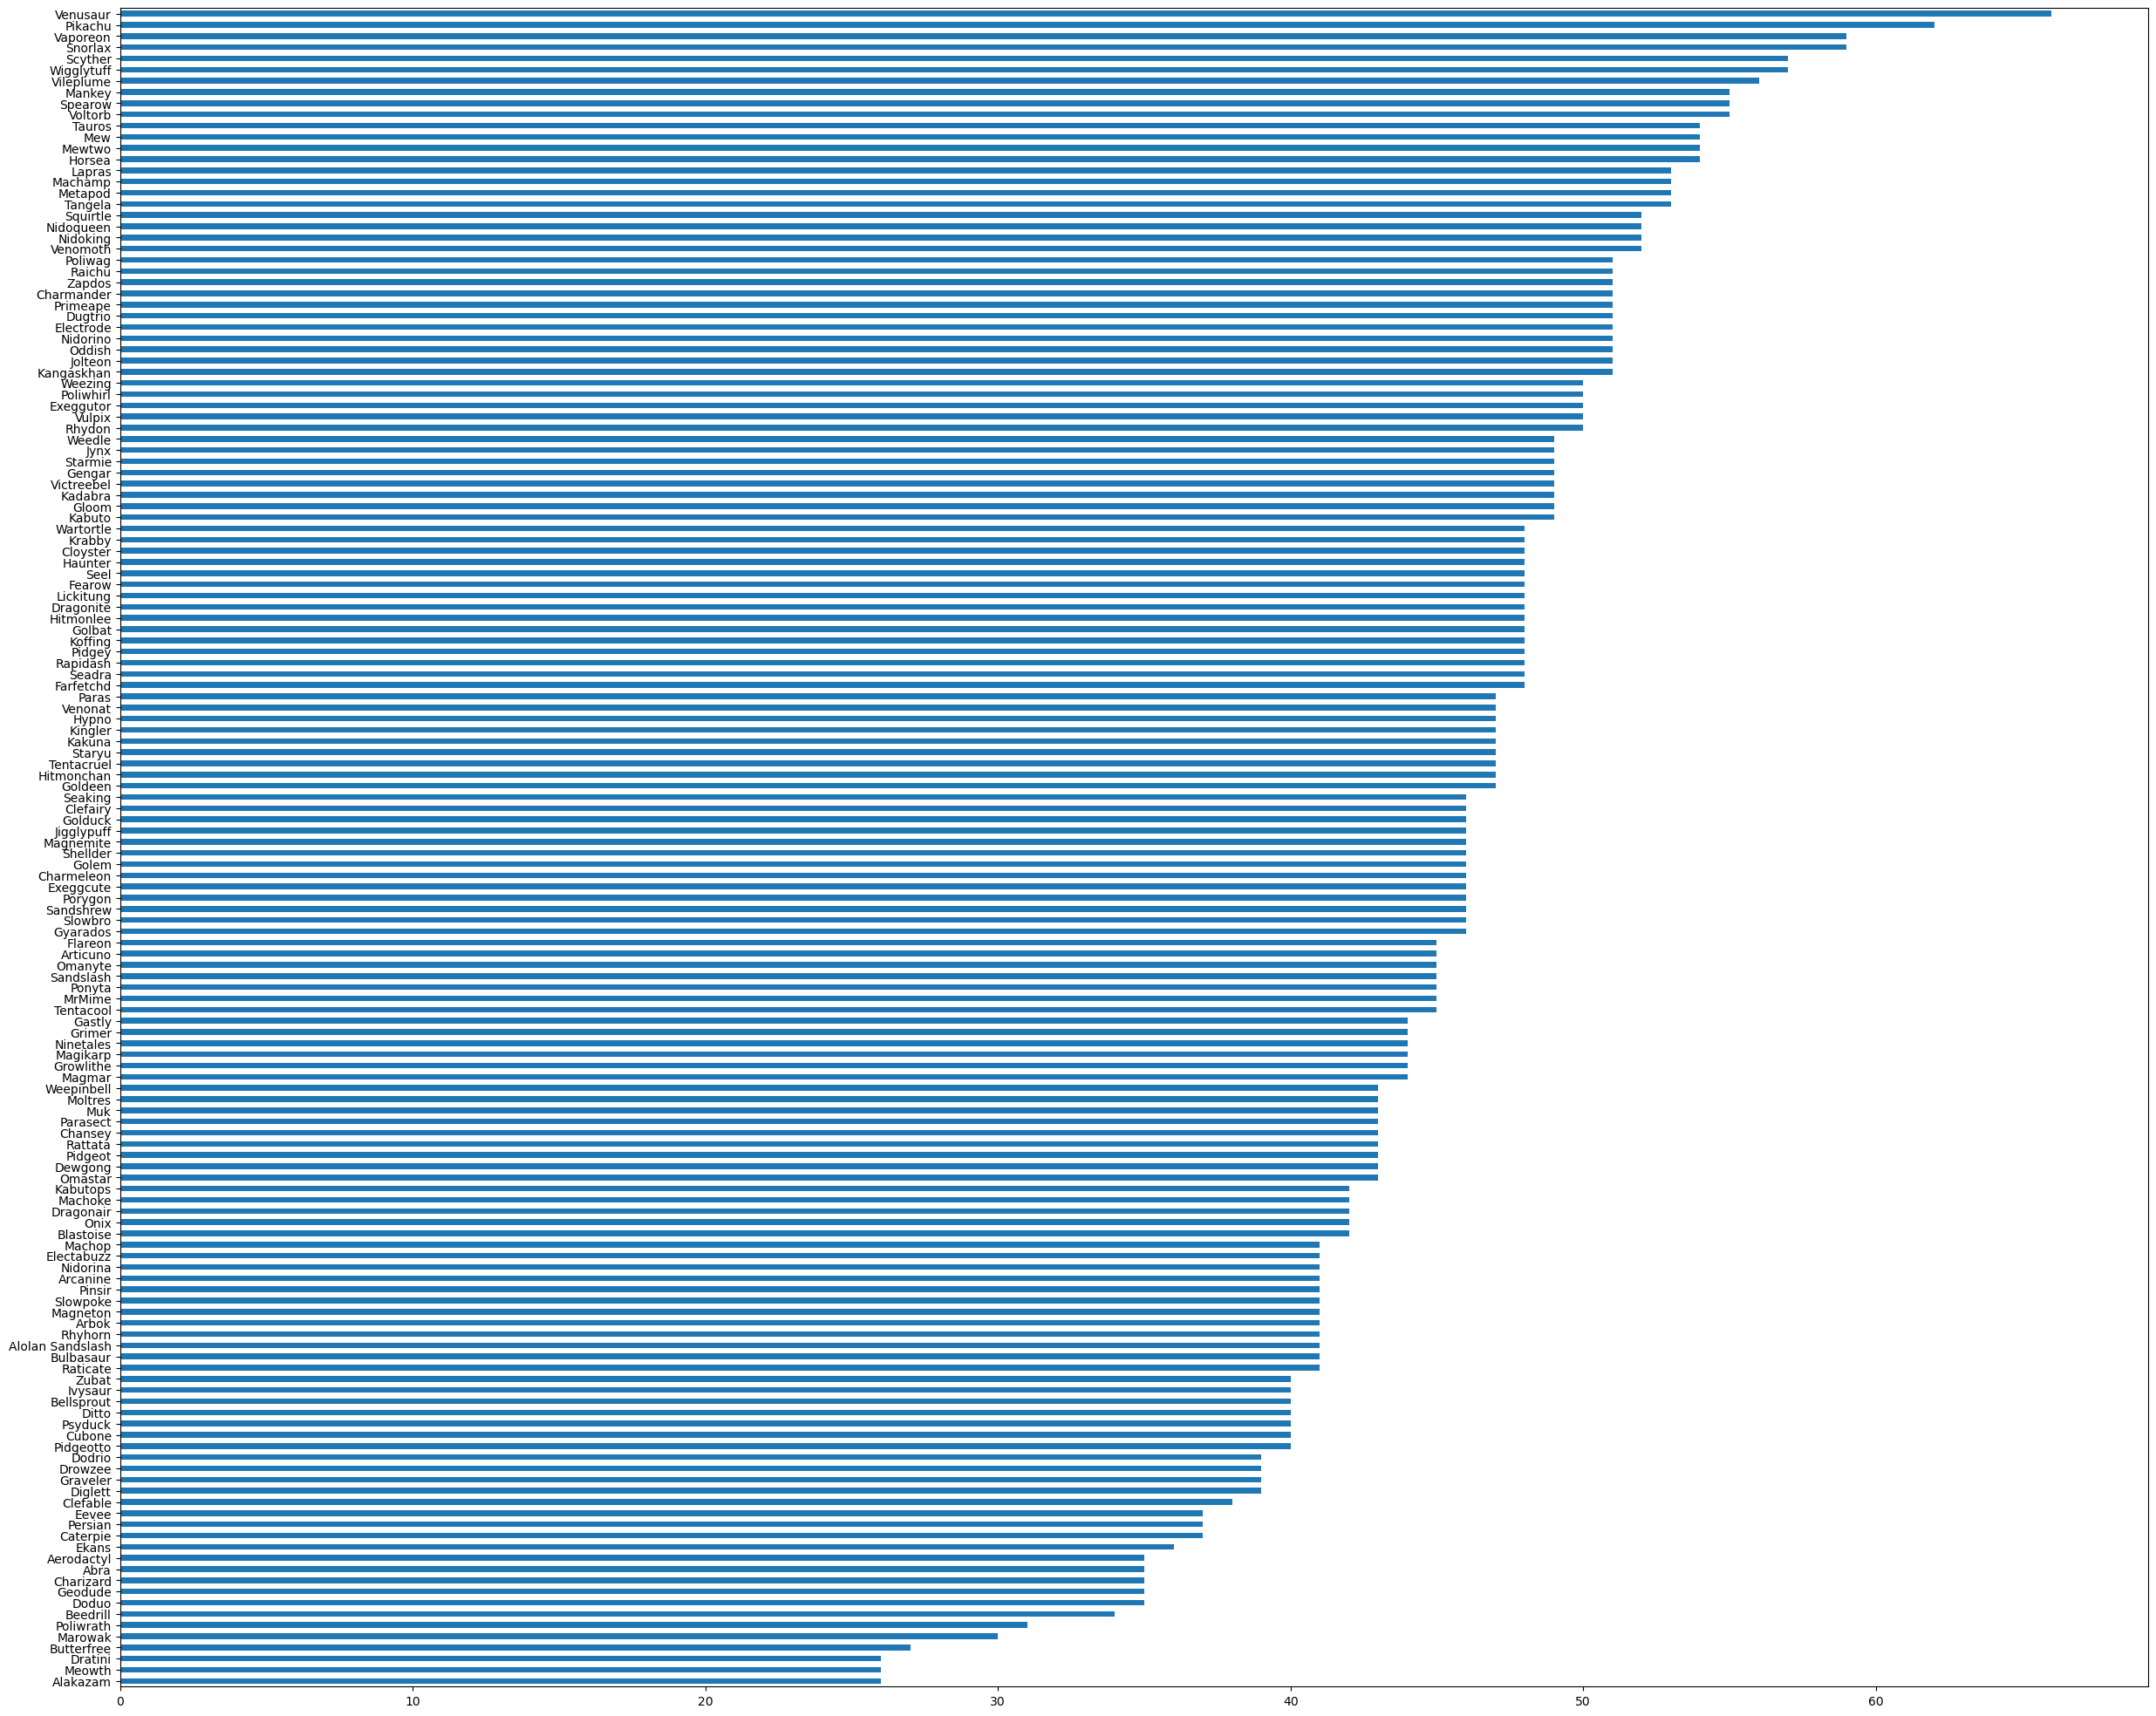

In [7]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [8]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

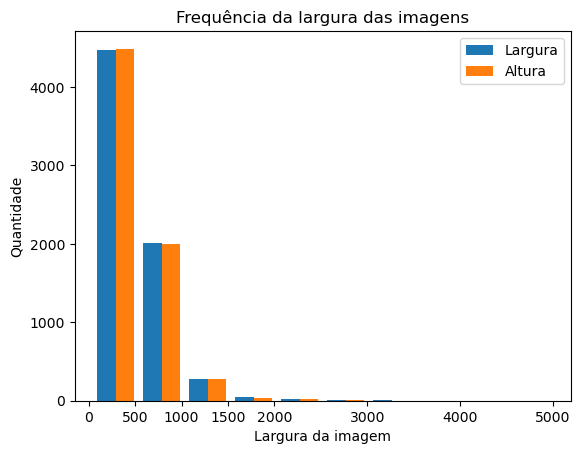

In [9]:
plt.hist([widths, heights])

plt.title("Frequência da largura das imagens")

plt.xlabel("Largura da imagem")
plt.ylabel("Quantidade")

plt.legend(["Largura", "Altura"])

plt.xticks([0, 500, 1000, 1500, 2000, 3000, 4000, 5000])

plt.show()

In [10]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [11]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [12]:
print(f"Tamanho da maior imagem em relação a \nwidth: {min(widths)} \nheight: {min(heights)}")

Tamanho da maior imagem em relação a 
width: 43 
height: 42


In [13]:
print(f"Tamanho da maior imagem em relação a \nwidth: {max(widths)} \nheight: {max(heights)}")

Tamanho da maior imagem em relação a 
width: 5000 
height: 4356


In [14]:
largura = math.floor(mean_width)
altura = math.floor(mean_height)

## Gerando mais imagens a partir do dataset

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [16]:
data_images_generator = ImageDataGenerator(rescale=1./255, # rescalar
                                            rotation_range=40, # rotacionar imagem
                                            width_shift_range=0.2, # deslocamento horizontal
                                            height_shift_range=0.2, # deslocamento vertical
                                            shear_range=0.2, # cisalhamento
                                            zoom_range=0.2, # zoom
                                            horizontal_flip=True, # inverter horizontalmente
                                            fill_mode='nearest')

In [17]:
#data_gen = data_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
#                                                     directory=diretorio,
#                                                     shuffle=True,
#                                                     target_size=(largura,altura))

data_gen = data_images_generator.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=True,
                                                     target_size=(largura,altura))

Found 6820 validated image filenames belonging to 150 classes.


C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [18]:
data_gen.class_indices

{'Abra': 0,
 'Aerodactyl': 1,
 'Alakazam': 2,
 'Alolan Sandslash': 3,
 'Arbok': 4,
 'Arcanine': 5,
 'Articuno': 6,
 'Beedrill': 7,
 'Bellsprout': 8,
 'Blastoise': 9,
 'Bulbasaur': 10,
 'Butterfree': 11,
 'Caterpie': 12,
 'Chansey': 13,
 'Charizard': 14,
 'Charmander': 15,
 'Charmeleon': 16,
 'Clefable': 17,
 'Clefairy': 18,
 'Cloyster': 19,
 'Cubone': 20,
 'Dewgong': 21,
 'Diglett': 22,
 'Ditto': 23,
 'Dodrio': 24,
 'Doduo': 25,
 'Dragonair': 26,
 'Dragonite': 27,
 'Dratini': 28,
 'Drowzee': 29,
 'Dugtrio': 30,
 'Eevee': 31,
 'Ekans': 32,
 'Electabuzz': 33,
 'Electrode': 34,
 'Exeggcute': 35,
 'Exeggutor': 36,
 'Farfetchd': 37,
 'Fearow': 38,
 'Flareon': 39,
 'Gastly': 40,
 'Gengar': 41,
 'Geodude': 42,
 'Gloom': 43,
 'Golbat': 44,
 'Goldeen': 45,
 'Golduck': 46,
 'Golem': 47,
 'Graveler': 48,
 'Grimer': 49,
 'Growlithe': 50,
 'Gyarados': 51,
 'Haunter': 52,
 'Hitmonchan': 53,
 'Hitmonlee': 54,
 'Horsea': 55,
 'Hypno': 56,
 'Ivysaur': 57,
 'Jigglypuff': 58,
 'Jolteon': 59,
 'Jynx': 60,

In [19]:
data_gen.samples

6820

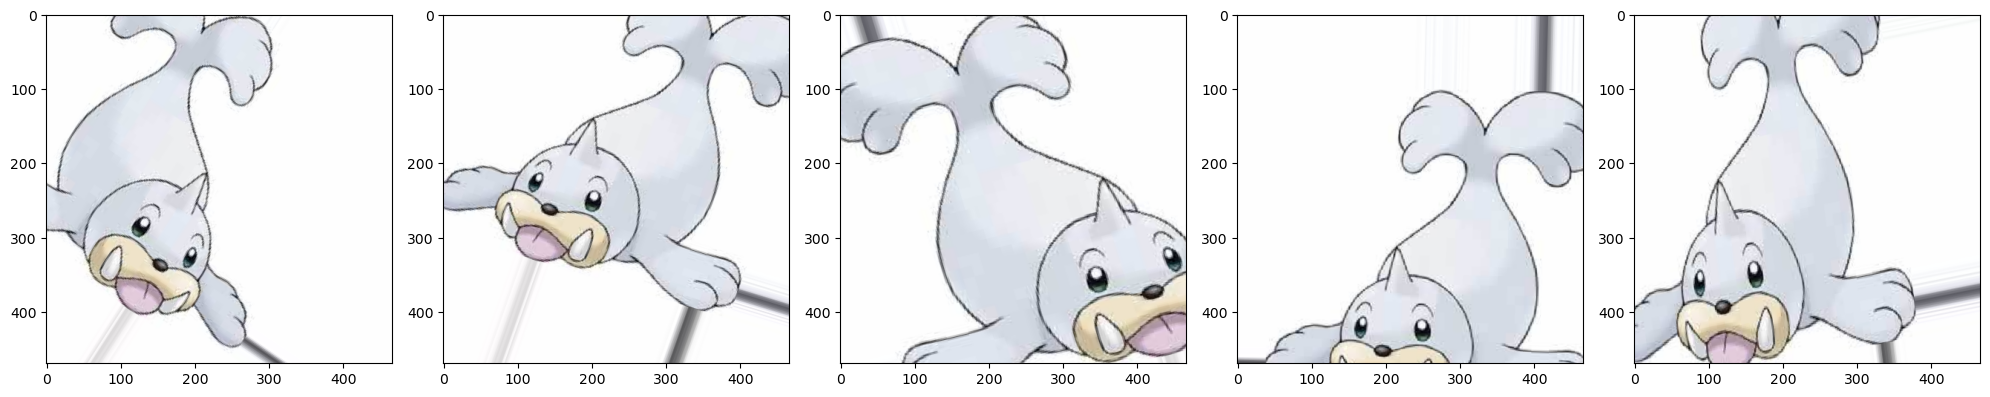

In [20]:
images = [data_gen[0][0][8] for i in range(5)]
plotImages(images)

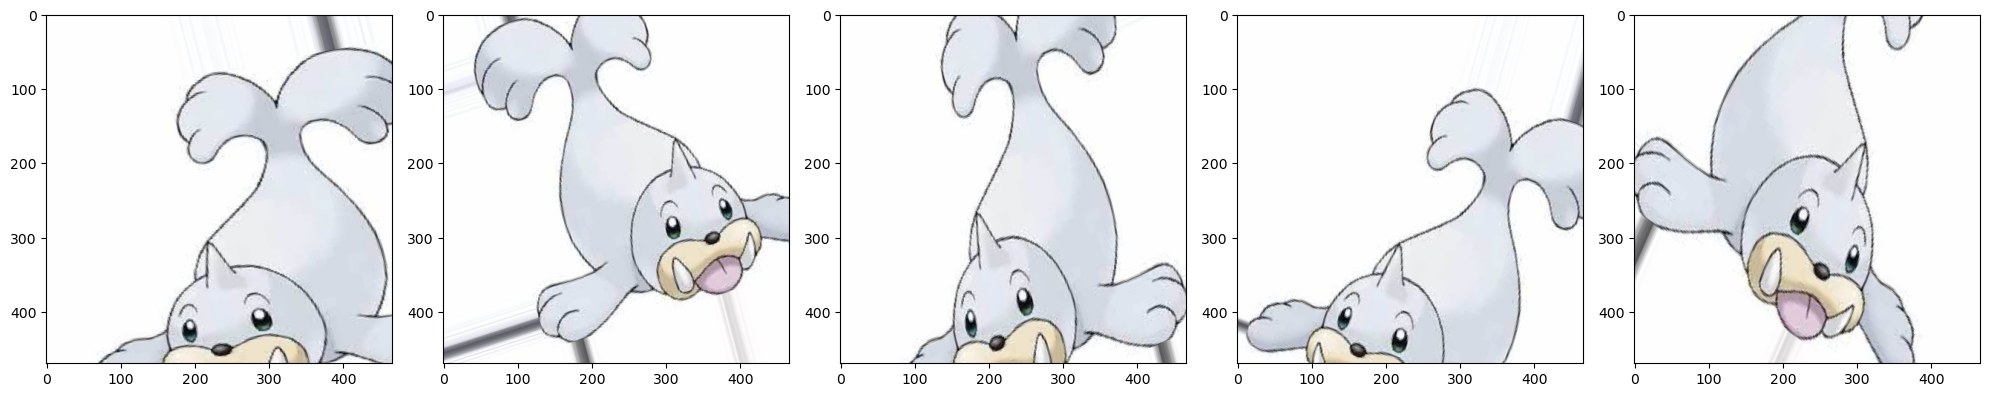

In [21]:
images = [data_gen[0][0][8] for i in range(465, 470)]
plotImages(images)

## Preparando Dados

In [24]:
def getEmbedder():
     return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    # return EfficientNetB3(weights='imagenet', include_top=False)
    # return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    # return InceptionV3(weights='imagenet', include_top=False)
    # return Xception(weights='imagenet', include_top=False)

def embedding(embedder, img_path, largura, altura, modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
        # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

def embeddingTest(embedder, img_path, largura, altura, modo_de_cor, n_transformations):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    
    array_img_transformed = []
    
    # FAZER NA IMAGEM ORINAL SEM MUDAR NADA
    img_transformed = image.img_to_array(img)

    embed = np.expand_dims(img_transformed, axis=0)
    # embed = preprocess_input(embed)

    features = embedder.predict(embed)
    
    array_img_transformed.append(features[0][0][0])
        
    for _ in range(n_transformations):
        
        img_transformed = data_images_generator.random_transform(image.img_to_array(img))

        embed = np.expand_dims(img_transformed, axis=0)
            # embed = preprocess_input(embed)

        features = embedder.predict(embed)
        
        array_img_transformed.append(features[0][0][0])

    return np.array(array_img_transformed)

def embeddingWithoutModel(img_path, largura, altura, modo_de_cor):
    
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    
    shape_entrada = largura*altura*1

    if(modo_de_cor == 'rgb'):
        shape_entrada = largura*altura*3

    if(modo_de_cor == 'rgba'):
        shape_entrada = largura*altura*4
    
    return embed.reshape(shape_entrada)

embedder = getEmbedder()

In [25]:
target = df_dados['target'].array

array_features = []
for x in dados:
    #array_features.append(embedding(embedder, x[0], largura, altura, modo_de_cor))
    array_features.extend(embeddingTest(embedder, x[0], largura, altura, modo_de_cor, 3))
    # array_features.append(embeddingWithoutModel(x[0], largura, altura, modo_de_cor))

scaler = preprocessing.StandardScaler()

# array_features = np.array(array_features, dtype=np.uint8)

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

1/1 [==============================] - 0s 180ms/step


KeyboardInterrupt: 

## Reduzindo a Dimensionalidade

In [ ]:
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50)
array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target

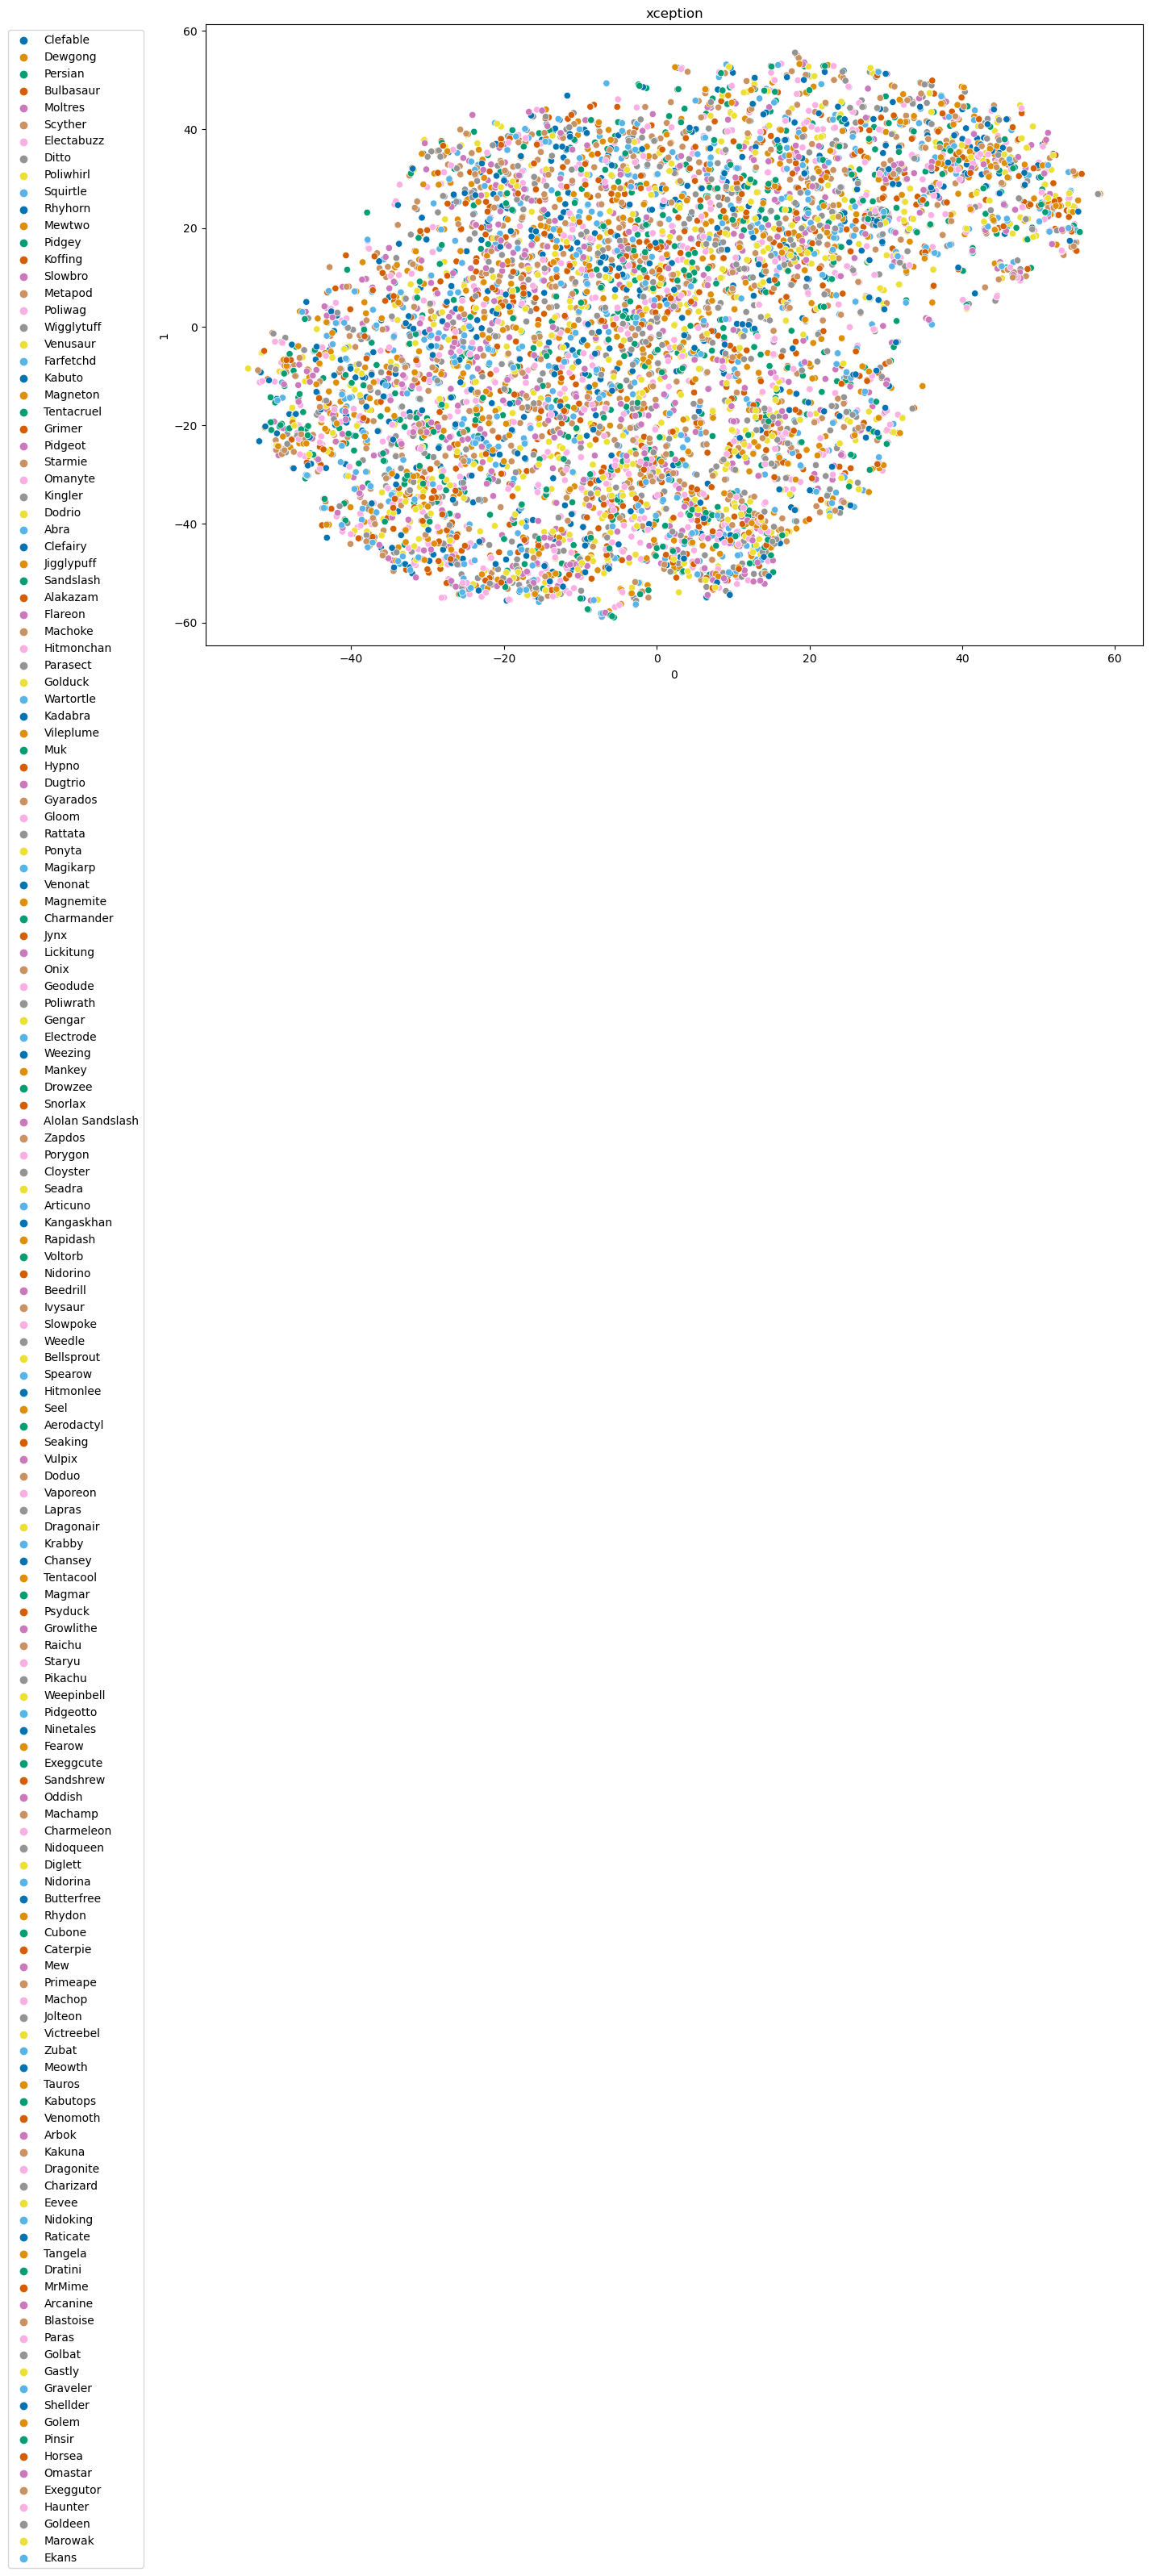

In [16]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name}", bbox_inches="tight")

plt.show()

## Mostrando só algumas classes da redução de dimensionalidade

In [ ]:
ten_classes = df_tsne.unique()[0:10]

In [ ]:
df_tsne_filter_by_ten_classes = df_tsne[df_tsne.includes(ten_classes)]

## Treinando e Validando o Modelo

In [17]:
def getModel():
    # Ensemble
    return RandomForestClassifier(n_jobs=12)
    # return AdaBoostClassifier()

    # Linear
    # return LogisticRegression()#n_jobs=12, solver='sag', multi_class='ovr')
    # return SGDClassifier(n_jobs=12,early_stopping=True,validation_fraction=0.05)

    # Tree
    # return DecisionTreeClassifier()
    
    # Neighbors
    # return KNeighborsClassifier(n_neighbors=3,n_jobs=12)
    
    # Support Vector Machines - SVM
    # return SVC()
    
    # Instalados a parte
    # return XGBClassifier()
    # return LGBMClassifier() - mais leve que o XGB

In [18]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target,test_size=percentege_test_size)

model = getModel().fit(X_treino, y_treino)

score = model.score(X_teste, y_teste)

score

C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.05934065934065934

## Validando

In [19]:
scores = cross_val_score(getModel(),df_features.values,target,cv=5)

np.mean(scores)

0.07164835164835164

## Visualizando Matriz de Confusão

In [ ]:
predicoes = cross_val_predict(getModel(),df_features.values,target,cv=5)

cm = confusion_matrix(target, predicoes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()